In [1]:
# 📘 Cell-by-Cell Notebook: Baseline Multi-Task Model on Split PlantVillage TFRecord

# 📌 Cell 1: Imports and Constants
import os
import tensorflow as tf
import wandb
from wandb.integration.keras import WandbCallback
from tensorflow.keras import layers, models, callbacks

# Constants
NUM_CROPS = 9
NUM_DISEASES = 33
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE



2025-03-24 18:02:16.122740: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-24 18:02:16.372442: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742819536.487533     747 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742819536.517756     747 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-24 18:02:16.812186: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# 📌 Cell 2: Initialize W&B with config
wandb.init(
    project="plantvillage_baseline_model",
    name="efficientnetv2b0_Training_preAugmented_run_2",
    config={
        "model": "EfficientNetV2B0",
        "optimizer": "Adam",
        "learning_rate": 1e-4,
        "batch_size": BATCH_SIZE,
        "loss_weights": {"crop_output": 1.0, "disease_output": 2.0},
        "epochs": 30,
        "augmentation": "None",
        "include_top": False,
        "input_shape": (224, 224, 3)
    }
)


wandb: Currently logged in as: gsrivatsa1398 (gsrivatsa1398-vellore-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
# 📌 Cell 3: TFRecord Paths
split_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split"
train_tfrecord = os.path.join(split_path, "train.tfrecord")
val_tfrecord = os.path.join(split_path, "val.tfrecord")
test_tfrecord = os.path.join(split_path, "test.tfrecord")



In [4]:
# 📌 Cell 4: TFRecord Parsing Functions
feature_description = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "crop": tf.io.FixedLenFeature([], tf.int64),
    "disease": tf.io.FixedLenFeature([], tf.int64)
}

def parse_tfrecord(example_proto):
    parsed = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed["image"], channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    crop = tf.one_hot(parsed["crop"], depth=NUM_CROPS)
    disease = tf.one_hot(parsed["disease"], depth=NUM_DISEASES)
    return image, {"crop_output": crop, "disease_output": disease}


In [5]:
# 📌 Cell 5: Load Dataset Function
def load_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset

train_dataset = load_dataset(train_tfrecord)
val_dataset = load_dataset(val_tfrecord)
test_dataset = load_dataset(test_tfrecord)

I0000 00:00:1742819548.150787     747 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
# 📌 Cell 6: Compute Class Weights
from collections import Counter
import numpy as np

def compute_class_weights(dataset):
    crop_counter = Counter()
    disease_counter = Counter()
    for batch in dataset:
        _, labels = batch
        crops = tf.argmax(labels["crop_output"], axis=1).numpy()
        diseases = tf.argmax(labels["disease_output"], axis=1).numpy()
        crop_counter.update(crops.tolist())
        disease_counter.update(diseases.tolist())

    total_crops = sum(crop_counter.values())
    total_diseases = sum(disease_counter.values())

    crop_weights = {i: total_crops / (len(crop_counter) * crop_counter[i]) for i in crop_counter}
    disease_weights = {i: total_diseases / (len(disease_counter) * disease_counter[i]) for i in disease_counter}

    return crop_weights, disease_weights

crop_class_weights, disease_class_weights = compute_class_weights(train_dataset)

crop_weights_array = np.array([crop_class_weights.get(i, 1.0) for i in range(NUM_CROPS)], dtype=np.float32)
disease_weights_array = np.array([disease_class_weights.get(i, 1.0) for i in range(NUM_DISEASES)], dtype=np.float32)


2025-03-24 18:02:28.609919: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:370] TFRecordDataset `buffer_size` is unspecified, default to 262144
2025-03-24 18:02:32.686036: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# 📌 Cell 7: Custom Weighted Loss Function
def weighted_categorical_crossentropy(weights_array):
    weights_tensor = tf.constant(weights_array, dtype=tf.float32)
    def loss_fn(y_true, y_pred):
        base_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        true_labels = tf.argmax(y_true, axis=-1)
        sample_weights = tf.gather(weights_tensor, true_labels)
        weighted_loss = base_loss * sample_weights
        return tf.reduce_mean(weighted_loss)
    return loss_fn

In [8]:
# 📌 Cell 8: Build Multi-Task Model
base_model = tf.keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet",
    pooling="avg"
)

x = layers.Dense(256, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001))(base_model.output)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.3)(x)

crop_output = layers.Dense(NUM_CROPS, activation="softmax", name="crop_output")(x)
disease_output = layers.Dense(NUM_DISEASES, activation="softmax", name="disease_output")(x)

model = models.Model(inputs=base_model.input, outputs=[crop_output, disease_output])

In [9]:
# 📌 Cell 9: Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss={
        "crop_output": weighted_categorical_crossentropy(crop_weights_array),
        "disease_output": weighted_categorical_crossentropy(disease_weights_array)
    },
    loss_weights={"crop_output": 1.0, "disease_output": 2.0},
    metrics={"crop_output": "accuracy", "disease_output": "accuracy"}
)


In [10]:
# 📌 Cell 10: Define Callbacks
model_save_path = os.path.join(split_path, "~/Multiple_Crop_Disease_Detection/Models/Base_Line_Model/baseline_model_split.keras")
cb = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/home/srivatsa/Multiple_Crop_Disease_Detection/Models/Base_Line_Model/baseline_model_split.keras",
        save_best_only=True,
        monitor="val_disease_output_accuracy",
        mode="max"
    ),
    WandbCallback(
        log_model=False,
        save_model=False,
        save_graph=False,
        log_weights=True  # ✅ Remove log_gradients to avoid internal optimizer issue
    )
]


wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


In [11]:
# 📌 Cell 11: Train Model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=cb
)

Epoch 1/30


I0000 00:00:1742819581.097618     909 service.cc:148] XLA service 0x7f963c0146f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742819581.098367     909 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-03-24 18:03:02.091477: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742819586.001025     909 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-03-24 18:03:11.475552: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22642_0', 244 bytes spill stores, 244 bytes spill loads

2025-03-24 18:03:11.487138: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot

    496/Unknown 144s 138ms/step - crop_output_accuracy: 0.5638 - crop_output_loss: 1.1358 - disease_output_accuracy: 0.4835 - disease_output_loss: 2.0152 - loss: 5.5936

2025-03-24 18:05:06.934705: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22642', 8 bytes spill stores, 8 bytes spill loads

2025-03-24 18:05:07.225897: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22642', 252 bytes spill stores, 252 bytes spill loads

2025-03-24 18:05:07.356765: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_22642_0', 8 bytes spill stores, 8 bytes spill loads

2025-03-24 18:05:07.688626: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24808', 96 bytes spill stores, 96 bytes spill loads

2025-03-24 18:05:07.836150: I external/local_xla/xla/str

    497/Unknown 186s 223ms/step - crop_output_accuracy: 0.5643 - crop_output_loss: 1.1347 - disease_output_accuracy: 0.4840 - disease_output_loss: 2.0133 - loss: 5.5887

2025-03-24 18:05:41.442708: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/srivatsa/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2025-03-24 18:05:44.934423: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 16 bytes spill stores, 16 bytes spill loads

2025-03-24 18:05:56.625869: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2412', 4 bytes spill stores, 4 bytes spill l

497/497 ━━━━━━━━━━━━━━━━━━━━ 209s 268ms/step - crop_output_accuracy: 0.5647 - crop_output_loss: 1.1336 - disease_output_accuracy: 0.4845 - disease_output_loss: 2.0115 - loss: 5.5838 - val_crop_output_accuracy: 0.9143 - val_crop_output_loss: 0.3403 - val_disease_output_accuracy: 0.8053 - val_disease_output_loss: 0.7301 - val_loss: 2.2215
Epoch 2/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - crop_output_accuracy: 0.9751 - crop_output_loss: 0.1015 - disease_output_accuracy: 0.9483 - disease_output_loss: 0.2130 - loss: 0.9460  

2025-03-24 18:07:22.790988: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


497/497 ━━━━━━━━━━━━━━━━━━━━ 80s 161ms/step - crop_output_accuracy: 0.9751 - crop_output_loss: 0.1015 - disease_output_accuracy: 0.9483 - disease_output_loss: 0.2130 - loss: 0.9458 - val_crop_output_accuracy: 0.9925 - val_crop_output_loss: 0.0228 - val_disease_output_accuracy: 0.9741 - val_disease_output_loss: 0.0786 - val_loss: 0.5882
Epoch 3/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 77s 154ms/step - crop_output_accuracy: 0.9896 - crop_output_loss: 0.0429 - disease_output_accuracy: 0.9753 - disease_output_loss: 0.0959 - loss: 0.6388 - val_crop_output_accuracy: 0.9942 - val_crop_output_loss: 0.0137 - val_disease_output_accuracy: 0.9803 - val_disease_output_loss: 0.0611 - val_loss: 0.5267
Epoch 4/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - crop_output_accuracy: 0.9944 - crop_output_loss: 0.0241 - disease_output_accuracy: 0.9861 - disease_output_loss: 0.0565 - loss: 0.5228  

2025-03-24 18:09:57.219770: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


497/497 ━━━━━━━━━━━━━━━━━━━━ 76s 153ms/step - crop_output_accuracy: 0.9944 - crop_output_loss: 0.0241 - disease_output_accuracy: 0.9861 - disease_output_loss: 0.0565 - loss: 0.5228 - val_crop_output_accuracy: 0.9827 - val_crop_output_loss: 0.0865 - val_disease_output_accuracy: 0.9290 - val_disease_output_loss: 0.2560 - val_loss: 0.9680
Epoch 5/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 79s 158ms/step - crop_output_accuracy: 0.9959 - crop_output_loss: 0.0167 - disease_output_accuracy: 0.9896 - disease_output_loss: 0.0389 - loss: 0.4580 - val_crop_output_accuracy: 0.9684 - val_crop_output_loss: 0.1641 - val_disease_output_accuracy: 0.8842 - val_disease_output_loss: 0.4304 - val_loss: 1.3694
Epoch 6/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 75s 151ms/step - crop_output_accuracy: 0.9967 - crop_output_loss: 0.0140 - disease_output_accuracy: 0.9938 - disease_output_loss: 0.0278 - loss: 0.4076 - val_crop_output_accuracy: 0.9899 - val_crop_output_loss: 0.0350 - val_disease_output_accuracy: 0.9341 - val_disease_out

2025-03-24 18:15:05.641292: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


497/497 ━━━━━━━━━━━━━━━━━━━━ 76s 153ms/step - crop_output_accuracy: 0.9978 - crop_output_loss: 0.0093 - disease_output_accuracy: 0.9937 - disease_output_loss: 0.0208 - loss: 0.3317 - val_crop_output_accuracy: 0.9968 - val_crop_output_loss: 0.0176 - val_disease_output_accuracy: 0.9768 - val_disease_output_loss: 0.0838 - val_loss: 0.4435
Epoch 9/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 78s 158ms/step - crop_output_accuracy: 0.9982 - crop_output_loss: 0.0075 - disease_output_accuracy: 0.9948 - disease_output_loss: 0.0191 - loss: 0.2967 - val_crop_output_accuracy: 0.9931 - val_crop_output_loss: 0.0240 - val_disease_output_accuracy: 0.9731 - val_disease_output_loss: 0.0867 - val_loss: 0.4260
Epoch 10/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - crop_output_accuracy: 0.9983 - crop_output_loss: 0.0064 - disease_output_accuracy: 0.9962 - disease_output_loss: 0.0139 - loss: 0.2557 - val_crop_output_accuracy: 0.9827 - val_crop_output_loss: 0.0355 - val_disease_output_accuracy: 0.9437 - val_disease_ou

2025-03-24 18:25:23.485707: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


497/497 ━━━━━━━━━━━━━━━━━━━━ 79s 159ms/step - crop_output_accuracy: 0.9993 - crop_output_loss: 0.0036 - disease_output_accuracy: 0.9980 - disease_output_loss: 0.0066 - loss: 0.1154 - val_crop_output_accuracy: 0.9675 - val_crop_output_loss: 0.1757 - val_disease_output_accuracy: 0.9039 - val_disease_output_loss: 0.4048 - val_loss: 1.0738


In [12]:
# 📌 Cell 12: Evaluate Model
test_metrics = model.evaluate(test_dataset)
print("\n✅ Final Test Evaluation:", test_metrics)

     69/Unknown 4s 47ms/step - crop_output_accuracy: 0.9971 - crop_output_loss: 0.0052 - disease_output_accuracy: 0.9892 - disease_output_loss: 0.0489 - loss: 0.2781 

2025-03-24 18:25:27.093639: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2412', 4 bytes spill stores, 4 bytes spill loads

2025-03-24 18:25:27.874616: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2412_0', 256 bytes spill stores, 256 bytes spill loads

2025-03-24 18:25:28.026027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2412', 252 bytes spill stores, 252 bytes spill loads



71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - crop_output_accuracy: 0.9971 - crop_output_loss: 0.0052 - disease_output_accuracy: 0.9891 - disease_output_loss: 0.0490 - loss: 0.2783

✅ Final Test Evaluation: [0.2845240533351898, 0.005982763133943081, 0.0517130121588707, 0.9964765310287476, 0.9867870807647705]


# Generate Plots

In [13]:
import matplotlib.pyplot as plt
import os

# Create directory
plot_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Baseline_Model/Plots"
os.makedirs(plot_path, exist_ok=True)

# Plot curves for all metrics
def plot_metric(history, metric, save_name):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history[metric], label=f'Train {metric}')
    if f'val_{metric}' in history.history:
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    plt.title(f"{metric.replace('_', ' ').title()} Curve")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(plot_path, save_name))
    plt.close()

# List of metrics to plot
metrics_to_plot = [
    "loss", "crop_output_loss", "disease_output_loss",
    "crop_output_accuracy", "disease_output_accuracy"
]

for metric in metrics_to_plot:
    plot_metric(history, metric, f"{metric}_curve.png")


In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Get predictions
crop_preds = []
crop_true = []
disease_preds = []
disease_true = []

for batch in test_dataset:
    images, labels = batch
    preds = model.predict(images, verbose=0)
    
    crop_preds.extend(np.argmax(preds[0], axis=1))
    disease_preds.extend(np.argmax(preds[1], axis=1))
    crop_true.extend(np.argmax(labels["crop_output"].numpy(), axis=1))
    disease_true.extend(np.argmax(labels["disease_output"].numpy(), axis=1))

# Plot function
def plot_conf_matrix(true_labels, pred_labels, num_classes, title, save_name):
    cm = confusion_matrix(true_labels, pred_labels, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(os.path.join(plot_path, save_name))
    plt.close()

# Plot Confusion Matrices
plot_conf_matrix(crop_true, crop_preds, NUM_CROPS, "Crop Classification Confusion Matrix", "crop_confusion_matrix.png")
plot_conf_matrix(disease_true, disease_preds, NUM_DISEASES, "Disease Classification Confusion Matrix", "disease_confusion_matrix.png")


2025-03-24 18:25:41.999582: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294_0', 104 bytes spill stores, 136 bytes spill loads

2025-03-24 18:25:42.157242: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294', 16 bytes spill stores, 16 bytes spill loads

2025-03-24 18:25:42.495127: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294', 228 bytes spill stores, 228 bytes spill loads

2025-03-24 18:25:58.528347: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294', 16 bytes spill stores, 16 bytes spill loads

2025-03-24 18:25:58.633752: I external/local_xla/xla/s

In [15]:
from sklearn.metrics import classification_report

# Save classification reports to .txt
with open(os.path.join(plot_path, "crop_classification_report.txt"), "w") as f:
    f.write(classification_report(crop_true, crop_preds))

with open(os.path.join(plot_path, "disease_classification_report.txt"), "w") as f:
    f.write(classification_report(disease_true, disease_preds))

print("✅ Classification reports saved successfully!")


✅ Classification reports saved successfully!


/home/srivatsa/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Extracting embeddings: 71it [00:21,  3.36it/s]
/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/srivatsa/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


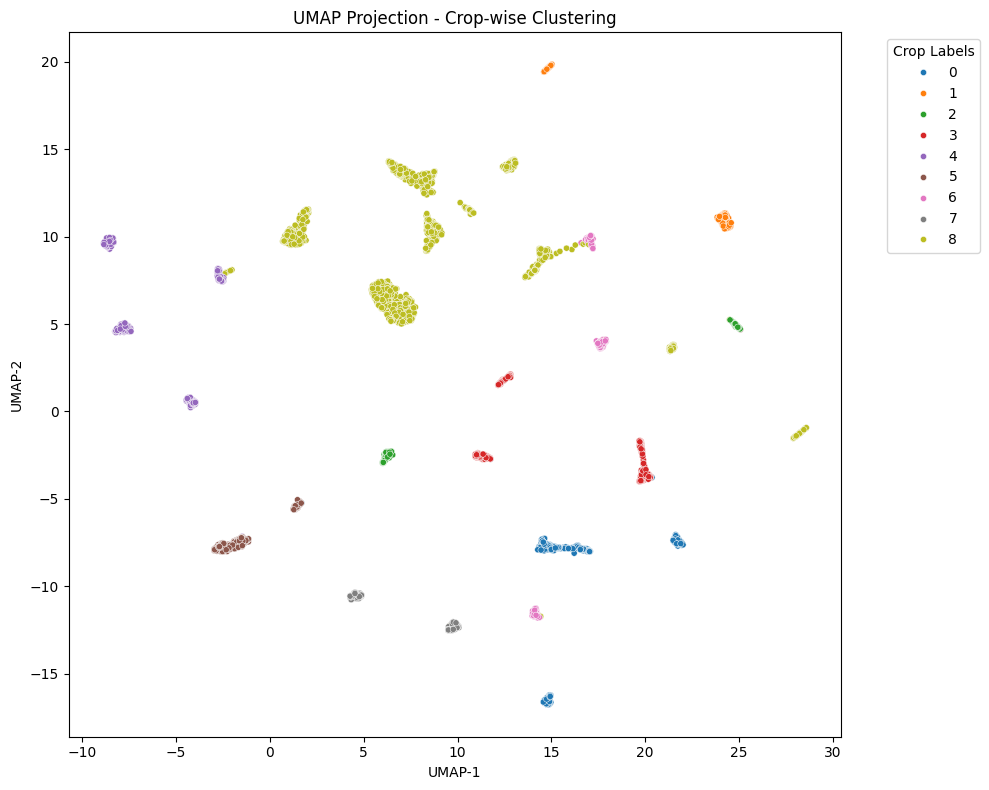

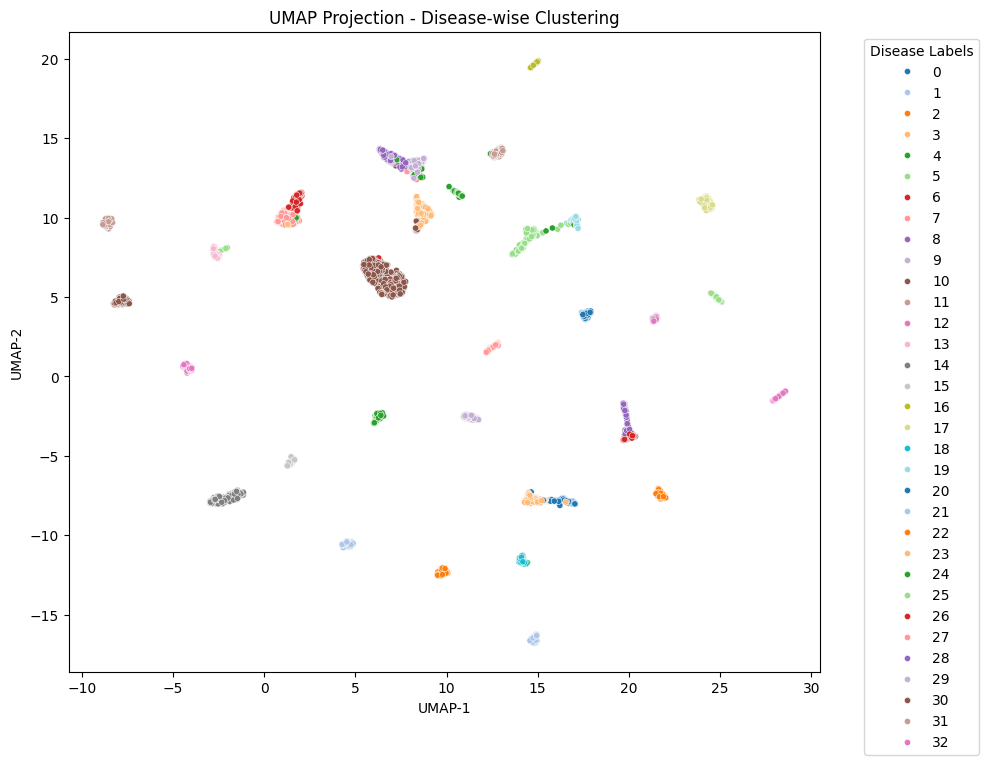

/home/srivatsa/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


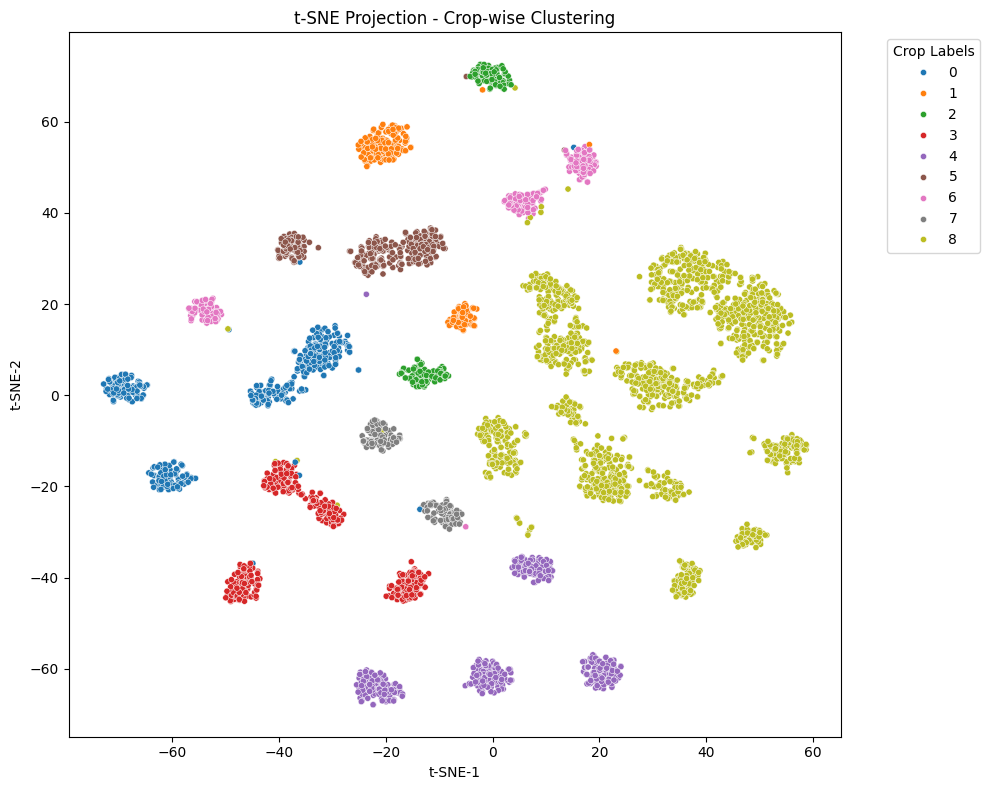

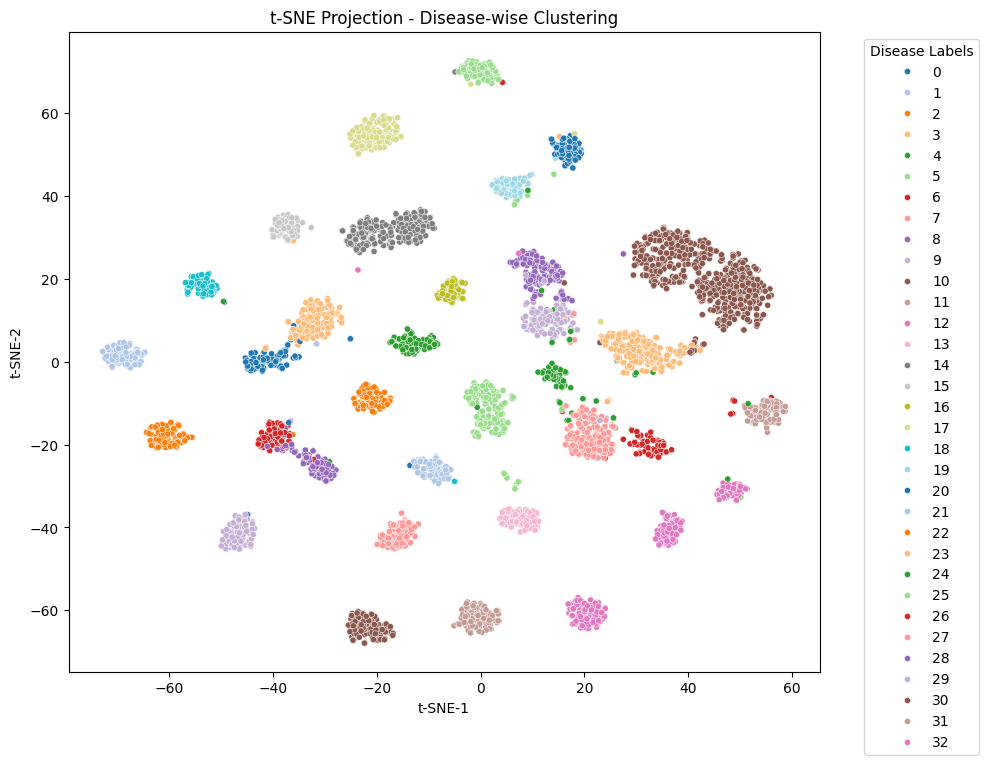

In [16]:
# 📌 Step 1: Import Required Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.manifold import TSNE
from tqdm import tqdm
import os

# 📌 Step 2: Set Paths
model_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Models/Base_Line_Model/baseline_model_split.keras"
output_dir = "/home/srivatsa/Multiple_Crop_Disease_Detection/reports/Baseline_Model/Plots"
os.makedirs(output_dir, exist_ok=True)

# 📌 Step 3: Load Trained Model
model = tf.keras.models.load_model(model_path, compile=False)

# 📌 Step 4: Build Feature Extractor Model (Intermediate Embedding Layer)
# Extract features from the penultimate layer (before crop/disease heads)
feature_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-4].output)

# 📌 Step 5: Load Dataset Again (if not already)
def load_dataset(path, batch_size=64):
    dataset = tf.data.TFRecordDataset(path)
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "crop": tf.io.FixedLenFeature([], tf.int64),
        "disease": tf.io.FixedLenFeature([], tf.int64)
    }

    def parse_tfrecord(example_proto):
        parsed = tf.io.parse_single_example(example_proto, feature_description)
        image = tf.image.decode_jpeg(parsed["image"], channels=3)
        image = tf.image.resize(image, [224, 224])
        image = tf.cast(image, tf.float32) / 255.0
        return image, (parsed["crop"], parsed["disease"])

    dataset = dataset.map(parse_tfrecord).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Update this path if using a different TFRecord
tfrecord_path = "/home/srivatsa/Multiple_Crop_Disease_Detection/Dataset/PlantVillage_Structured/AUG_TFRecord/split/test.tfrecord"
test_dataset = load_dataset(tfrecord_path)

# 📌 Step 6: Extract Embeddings + Labels
all_features, all_crops, all_diseases = [], [], []

for batch_images, (batch_crops, batch_diseases) in tqdm(test_dataset, desc="Extracting embeddings"):
    features = feature_model(batch_images).numpy()
    all_features.append(features)
    all_crops.append(batch_crops.numpy())
    all_diseases.append(batch_diseases.numpy())

features = np.concatenate(all_features, axis=0)
crop_labels = np.concatenate(all_crops, axis=0)
disease_labels = np.concatenate(all_diseases, axis=0)

# 📌 Step 7: UMAP Projection (2D)
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
umap_2d = umap_model.fit_transform(features)

# 📌 Step 8: Plot UMAP — Crop-wise
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_2d[:, 0], y=umap_2d[:, 1], hue=crop_labels, palette="tab10", legend="full", s=20)
plt.title("UMAP Projection - Crop-wise Clustering")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Crop Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/UMAP_CropWise.png")
plt.show()

# 📌 Step 9: Plot UMAP — Disease-wise
plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_2d[:, 0], y=umap_2d[:, 1], hue=disease_labels, palette="tab20", legend="full", s=20)
plt.title("UMAP Projection - Disease-wise Clustering")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Disease Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/UMAP_DiseaseWise.png")
plt.show()

# 📌 Step 10: t-SNE Projection (2D)
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42).fit_transform(features)

# 📌 Step 11: Plot t-SNE — Crop-wise
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_2d[:, 0], y=tsne_2d[:, 1], hue=crop_labels, palette="tab10", legend="full", s=20)
plt.title("t-SNE Projection - Crop-wise Clustering")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend(title="Crop Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/tSNE_CropWise.png")
plt.show()

# 📌 Step 12: Plot t-SNE — Disease-wise
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_2d[:, 0], y=tsne_2d[:, 1], hue=disease_labels, palette="tab20", legend="full", s=20)
plt.title("t-SNE Projection - Disease-wise Clustering")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend(title="Disease Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{output_dir}/tSNE_DiseaseWise.png")
plt.show()
